# Classification of cogntive performance

In [1]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
from matplotlib.dates import WeekdayLocator
import plotly.express as px
import seaborn as sns

from sklearn import metrics, svm
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score

import warnings
warnings.filterwarnings('ignore')

work_dir = '/Users/mcmahonmc/Github/machine-learning-2021/final_project/'
data_dir = work_dir + 'data/'
results_dir = work_dir + 'results/24hrday_ncomponents/'

## Load data

In [2]:
actdf = pd.read_csv(data_dir + 'actigraphy_data_24hrday_df.csv').drop(['40768', '30242', '30412', '30433'], axis=1)
print('actigraphy df')
print(actdf.shape)

targets = pd.read_csv(data_dir + 'target_data.csv')
targets = targets.set_index('subject').drop([40768, 30242, 30412, 30433])
print('targets')
print(targets.shape)

targets[:5]

manifold_2D_pca = pd.read_csv(results_dir + 'pca.csv')
manifold_2D_iso = pd.read_csv(results_dir + 'isomap.csv')
manifold_2D_lle = pd.read_csv(results_dir + 'lle.csv')

manifold_2D_pca_n = pd.read_csv(results_dir + 'pca_random.csv')
manifold_2D_iso_n = pd.read_csv(results_dir + 'isomap_random.csv')
manifold_2D_lle_n = pd.read_csv(results_dir + 'lle_random.csv')

actigraphy df
(24, 121)
targets
(112, 279)


In [3]:
manifold_2D_pca.head()

,Component 1,Component 2,Component 3
0,0.168038,-0.198988,-0.112640
1,0.020272,0.116818,-0.164727
2,0.975086,-0.306216,0.099980
3,0.820116,-0.199341,-0.185912
4,0.159610,-0.287852,0.025626


In [5]:
manifold_2D_pca.shape

(112, 3)

In [4]:
drop_subs = [ subject for subject in actdf.columns if int(subject) not in targets.index.values ]
drop_subs_idx = [ actdf.columns.get_loc(subject) for subject in actdf.columns if int(subject) not in targets.index.values ]

actdf = actdf.drop(drop_subs, axis=1)[:-3]
targets = targets

print(actdf.shape)
print(targets.shape)

(21, 112)
(112, 279)


## Correlations

MAE: Average absolute error between the model prediction and the actual observed data. <br>
RMSE: Lower the RMSE, the more closely a model is able to predict the actual observations.

In [44]:
targets = targets.reset_index()

[Text(0.5, 1.0, 'PCA Component Correlations with Cognitive Measures')]

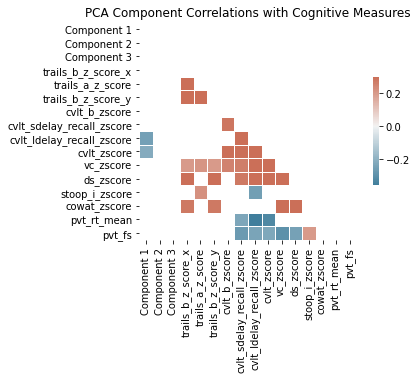

In [45]:
corr = manifold_2D_pca.join(targets[[col for col in targets.columns if 'z_score' in col] +
                                   [col for col in targets.columns if 'zscore' in col] + ['pvt_rt_mean', 'pvt_fs']].reset_index().drop(['cvlt_ldelay_cue_recall_zscore',
       'cvlt_recognition_hits_zscore', 'cvlt_recognition_fp_zscore', 
                               'cvlt_sdelay_cued_zscore', 'index'], axis=1)).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr[np.abs(corr) > .2], mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title = 'PCA Component Correlations with Cognitive Measures')

[Text(0.5, 1.0, 'Isomap Component Correlations with Cognitive Measures')]

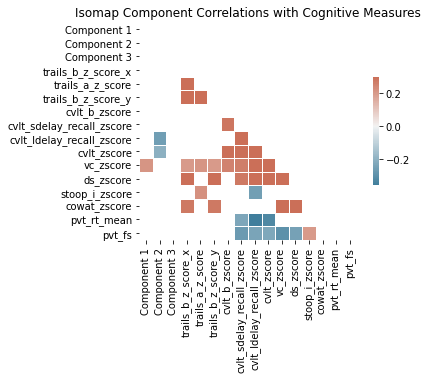

In [46]:
corr = manifold_2D_iso.join(targets[[col for col in targets.columns if 'z_score' in col] +
                                   [col for col in targets.columns if 'zscore' in col] + ['pvt_rt_mean', 'pvt_fs']].reset_index().drop(['cvlt_ldelay_cue_recall_zscore',
       'cvlt_recognition_hits_zscore', 'cvlt_recognition_fp_zscore', 
                               'cvlt_sdelay_cued_zscore', 'index'], axis=1)).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr[np.abs(corr) > .2], mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title = 'Isomap Component Correlations with Cognitive Measures')

[Text(0.5, 1.0, 'LLE Component Correlations with Cognitive Measures')]

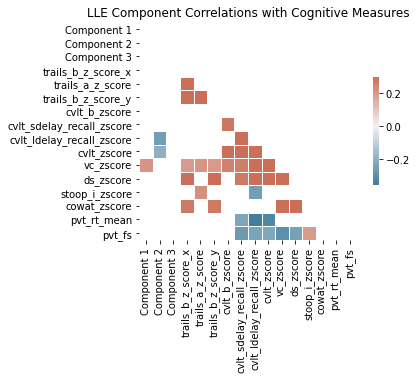

In [47]:
corr = manifold_2D_lle.join(targets[[col for col in targets.columns if 'z_score' in col] +
                                   [col for col in targets.columns if 'zscore' in col] + ['pvt_rt_mean', 'pvt_fs']].reset_index().drop(['cvlt_ldelay_cue_recall_zscore',
       'cvlt_recognition_hits_zscore', 'cvlt_recognition_fp_zscore', 
                               'cvlt_sdelay_cued_zscore', 'index'], axis=1)).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr[np.abs(corr) > .2], mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title = 'LLE Component Correlations with Cognitive Measures')

# SVM

[Datacamp](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)

In [50]:
import os
results_dir = os.getcwd() + '/results/'

manifold_2D_pca = manifold_2D_pca.reset_index(drop=True)
manifold_2D_iso = manifold_2D_iso.reset_index(drop=True)
manifold_2D_lle = manifold_2D_lle.reset_index(drop=True)

df = targets[[col for col in targets.columns if 'z_score' in col] + 
                [col for col in targets.columns if 'zscore' in col] + ['pvt_rt_mean', 'pvt_fs'] +
               ['group']].drop('trails_b_z_score_y', axis=1)

# lthresh = 0
# uthresh = 0

reduction_methods = ['pca', 'iso', 'lle']
n_splits=2
test_n = 0.3

kernel_methods = ['linear', 'poly', 'sigmoid', 'rbf']

trails_a_z_score


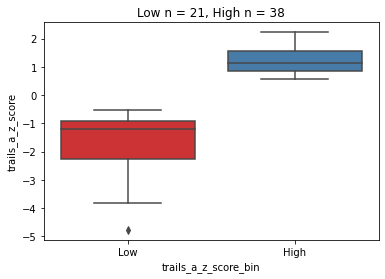

cvlt_b_zscore


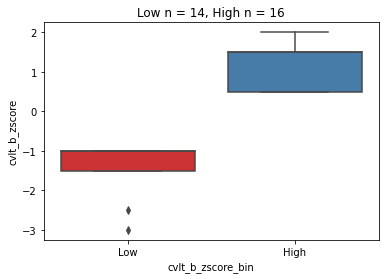

cvlt_sdelay_recall_zscore


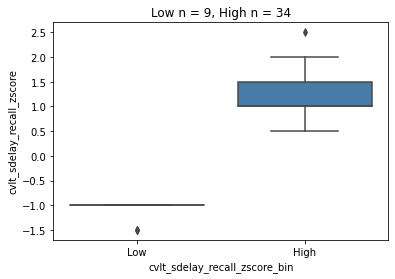

cvlt_sdelay_cued_zscore


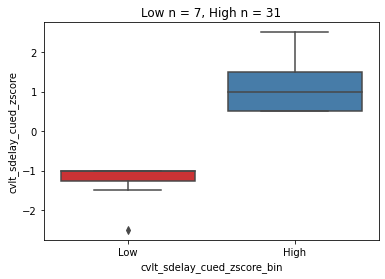

cvlt_ldelay_recall_zscore


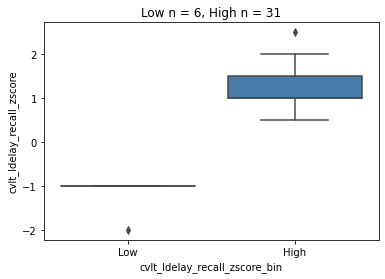

cvlt_ldelay_cue_recall_zscore


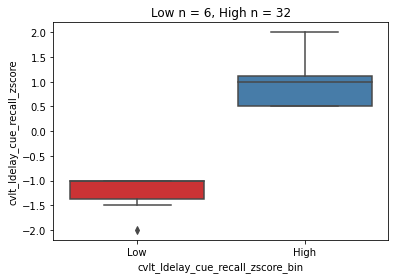

cvlt_recognition_hits_zscore


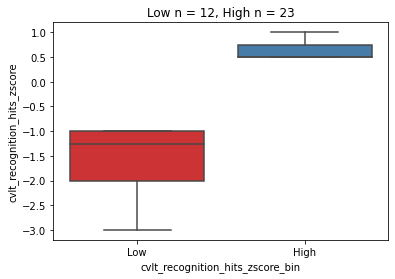

cvlt_recognition_fp_zscore


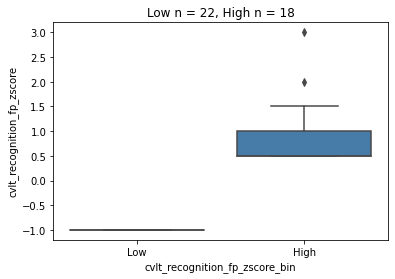

cvlt_zscore


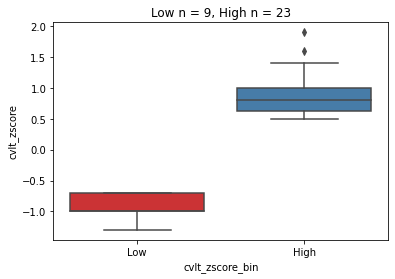

vc_zscore


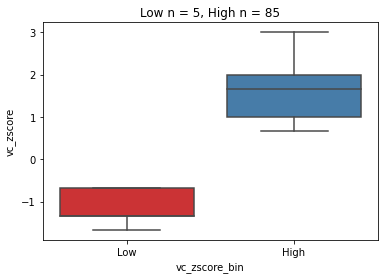

ds_zscore


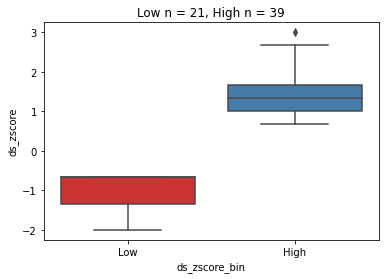

stoop_i_zscore


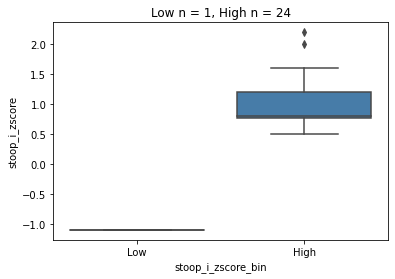

cowat_zscore


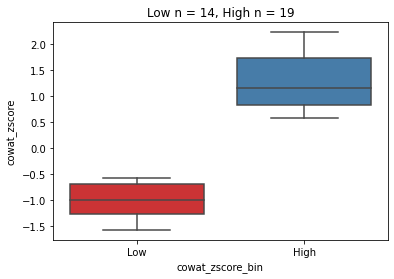

trails_b_z_score_x


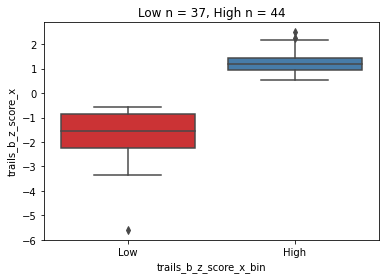

In [51]:
for y in df[[col for col in df.columns if col.endswith('score')] + ['trails_b_z_score_x']]:
    print(y)
    
    uthresh = .5 #np.percentile(df[y].dropna(), 67)
    lthresh = -.5 #np.percentile(df[y].dropna(), 33)
    
    df[y + '_bin'] = np.nan
    df[y + '_bin'] = np.where(df[y] >= uthresh, "High", np.nan)
    df[y + '_bin'] = np.where(df[y] < lthresh, "Low",  df[y + '_bin'] )
    
#     na_idx = np.where(y.isnull())[0]
    
#     # plot binarized target measures
    sns.boxplot(x = df[y + '_bin'],
                y = df[y], palette='Set1', order = ['Low', 'High']).set(title='Low n = %d, High n = %d' % 
                                                                        (len(df[y + '_bin'][df[y + '_bin'] == 'Low']),
                                                                        (len(df[y + '_bin'][df[y + '_bin'] == 'High']))))
    plt.show()
#     plt.savefig('%s/%s_bin_split.png' % (results_dir, str(outcome)), 
#                 dpi=300, bbox_inches='tight', facecolor='w')
    plt.close()
       

pvt_rt_mean


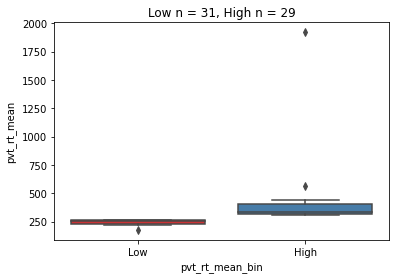

pvt_fs


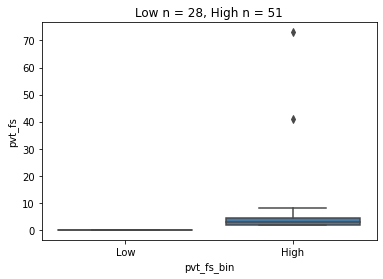

In [52]:
for y in df[['pvt_rt_mean', 'pvt_fs']]:
    print(y)
    
    uthresh = np.percentile(df[y].dropna(), 70)
    lthresh = np.percentile(df[y].dropna(), 32)
    
    df[y + '_bin'] = np.nan
    df[y + '_bin'] = np.where(df[y] >= uthresh, "High", np.nan)
    df[y + '_bin'] = np.where(df[y] < lthresh, "Low",  df[y + '_bin'] )
    
#     na_idx = np.where(y.isnull())[0]
    
#     # plot binarized target measures
    sns.boxplot(x = df[y + '_bin'],
                y = df[y], palette='Set1', order = ['Low', 'High']).set(title='Low n = %d, High n = %d' % 
                                                                        (len(df[y + '_bin'][df[y + '_bin'] == 'Low']),
                                                                        (len(df[y + '_bin'][df[y + '_bin'] == 'High']))))
    plt.show()
#     plt.savefig('%s/%s_bin_split.png' % (results_dir, str(outcome)), 
#                 dpi=300, bbox_inches='tight', facecolor='w')
    plt.close()
       

In [53]:
def bootstrap_svm(X, y_true, target_label, n_size, n_iterations, kernel_methods):
    import sys
    
    results = pd.DataFrame()
    cis = []
    
    try:
        
        for kernel_method in kernel_methods:
            
            stats = pd.DataFrame()
            for i in range(n_iterations):
                X_train, X_test, y_train, y_test = train_test_split(X, y_true, 
                                                                    test_size=n_size, 
                                                                    shuffle=True, 
                                                                    stratify=y_true)
                
                # fit model
                model = svm.SVC(kernel=kernel_method)
                model = model.fit(X_train, y_train) 
                
                
                # evaluate model
                y_pred = model.predict(X_test)
                stats = stats.append({'Accuracy': metrics.accuracy_score(y_test, y_pred),
                                     'Precision': metrics.precision_score(y_test, y_pred, average='weighted'),
                                     'Recall': metrics.recall_score(y_test, y_pred, average='weighted')},
                                     ignore_index=True)
            
            cis = stats.apply(lambda x: np.around(np.percentile(x,[2.5,97.5]), decimals=3))
            
            result_dict = {'target': target_label,
                    'total_sample_size':int(X.shape[0]),
                    'train_sample_size': int(X.shape[0] * (1-n_size)),
                    'test_sample_size': int(X.shape[0] * n_size),
                           'svm_kernel': kernel_method,
                           'n_iterations': int(n_iterations),
                           'svm_accuracy': stats['Accuracy'].dropna().mean(),
                           'svm_accuracy_ci': cis['Accuracy'].values,
                         'svm_precision': stats['Precision'].dropna().mean(), #metrics.precision_score(y_test, y_pred, average='weighted'),
                         'svm_precision_ci': cis['Precision'].values,
                           'svm_recall': stats['Recall'].dropna().mean(),
                           'svm_recall_ci': cis['Recall'].values}

            results = results.append(result_dict, ignore_index=True).sort_values('target').reset_index(drop=True)
        
    except Exception as e:
        print(e, "Error on line {}".format(sys.exc_info()[-1].tb_lineno))
            
    return results, stats, cis

In [54]:
n_iterations=500
n_size = 0.30
pd.set_option('display.float_format', '{:.3f}'.format)

## Age Group

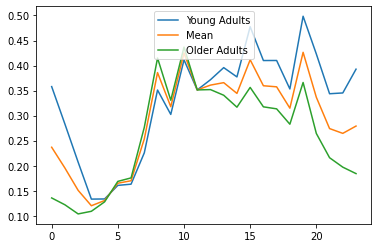

In [55]:
ya_idx, oa_idx = [np.where(targets['group'] == 'Young Adults'),
                 np.where(targets['group'] == 'Older Adults')]

sns.lineplot(x=range(0,len(x[0])), y=x[ya_idx].mean(axis=0), label='Young Adults')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[oa_idx].mean(axis=0), label='Older Adults')

plt.legend(loc='upper center')

plt.savefig(results_dir + 'ya_oa_activity.png', dpi=300, bbox_inches='tight', facecolor='w')

In [56]:
results_age = pd.DataFrame()

for reduction_method in reduction_methods:
    try:
        
        na_idx = np.where(df['group'] == 'nan')[0]

        X = eval('manifold_2D_' + reduction_method + '_n').drop(index=na_idx).values
        y_true = df['group'].drop(index=na_idx).values

        result, stats, cis = bootstrap_svm(X, y_true, 'age group', n_size, n_iterations, 
                                           kernel_methods=kernel_methods)
        result['dim_redx'] = reduction_method
        result['sil_score'] = metrics.silhouette_score(X, y_true, metric='euclidean')
        results_age = results_age.append(result)
    
    except Exception as e:
        print(e)

sil_idx = results_age.groupby(['target'])['sil_score'].transform(max) == results_age['sil_score']
results_age_best = results_age[sil_idx]
acc_idx = results_age_best.groupby(['target'])['svm_accuracy'].transform(max) == results_age_best['svm_accuracy']
results_age_best = results_age_best[acc_idx].groupby('target').first()
results_age_best

,total_sample_size,train_sample_size,test_sample_size,svm_kernel,n_iterations,svm_accuracy,svm_accuracy_ci,svm_precision,svm_precision_ci,svm_recall,svm_recall_ci,dim_redx,sil_score
target,,,,,,,,,,,,,
age group,112.000,78.000,33.000,linear,500.000,0.525,"[0.353, 0.559]",0.345,"[0.303, 0.513]",0.525,"[0.353, 0.559]",pca,-0.009


In [57]:
results_n = pd.DataFrame()

for reduction_method in reduction_methods:
    print(reduction_method)
    
    for y in df[[col for col in df.columns if col.endswith('_bin')] + ['pvt_rt_mean_bin', 'pvt_fs_bin']]:
        try:
            na_idx = np.where(df[y] == 'nan')[0]

            X = eval('manifold_2D_' + reduction_method + '_n').drop(index=na_idx).values
            y_true = np.delete(df[y].values, na_idx) 

            result, stats, cis = bootstrap_svm(X, y_true, y, n_size, n_iterations, kernel_methods=kernel_methods)
            result['dim_redx'] = reduction_method
            result['sil_score'] = metrics.silhouette_score(X, y_true, metric='euclidean')
            results_n = results_n.append(result)
     
        except Exception as e:
            print(e)
                         
sil_idx = results_n.groupby(['target'])['sil_score'].transform(max) == results_n['sil_score']
results_n_best = results_n[sil_idx]
acc_idx = results_n_best.groupby(['target'])['svm_accuracy'].transform(max) == results_n_best['svm_accuracy']
results_n_best = results_n_best[acc_idx].groupby('target').first()

results_n_best.reset_index(drop=True).to_latex(results_dir + 'results_random.tex', index=None, float_format="%.2f")
results_n_best

pca
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. Error on line 13
iso
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. Error on line 13
lle
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. Error on line 13


,total_sample_size,train_sample_size,test_sample_size,svm_kernel,n_iterations,svm_accuracy,svm_accuracy_ci,svm_precision,svm_precision_ci,svm_recall,svm_recall_ci,dim_redx,sil_score
target,,,,,,,,,,,,,
cowat_zscore_bin,33.000,23.000,9.000,rbf,500.000,0.672,"[0.4, 0.9]",0.680,"[0.333, 0.914]",0.672,"[0.4, 0.9]",iso,0.039
cvlt_b_zscore_bin,30.000,21.000,9.000,linear,500.000,0.594,"[0.333, 0.778]",0.600,"[0.238, 0.852]",0.594,"[0.333, 0.778]",iso,0.029
cvlt_ldelay_cue_recall_zscore_bin,38.000,26.000,11.000,linear,500.000,0.833,"[0.833, 0.833]",0.694,"[0.694, 0.694]",0.833,"[0.833, 0.833]",iso,-0.056
cvlt_ldelay_recall_zscore_bin,37.000,25.000,11.000,linear,500.000,0.833,"[0.833, 0.833]",0.694,"[0.694, 0.694]",0.833,"[0.833, 0.833]",pca,0.009
cvlt_recognition_fp_zscore_bin,40.000,28.000,12.000,linear,500.000,0.665,"[0.456, 0.833]",0.681,"[0.448, 0.881]",0.665,"[0.456, 0.833]",pca,0.057
cvlt_recognition_hits_zscore_bin,35.000,24.000,10.000,rbf,500.000,0.634,"[0.455, 0.727]",0.512,"[0.367, 0.809]",0.634,"[0.455, 0.727]",pca,0.002
cvlt_sdelay_cued_zscore_bin,38.000,26.000,11.000,poly,500.000,0.836,"[0.833, 0.917]",0.702,"[0.694, 0.924]",0.836,"[0.833, 0.917]",pca,-0.035
cvlt_sdelay_recall_zscore_bin,43.000,30.000,12.000,poly,500.000,0.788,"[0.692, 0.923]",0.696,"[0.577, 0.93]",0.788,"[0.692, 0.923]",pca,0.050
cvlt_zscore_bin,32.000,22.000,9.000,linear,500.000,0.694,"[0.6, 0.7]",0.491,"[0.467, 0.49]",0.694,"[0.6, 0.7]",pca,0.016


In [60]:
results = pd.DataFrame()

for reduction_method in reduction_methods:
    print(reduction_method)
    
    for y in df[[col for col in df.columns if col.endswith('_bin')] + ['pvt_rt_mean_bin', 'pvt_fs_bin']]:
        try:

            na_idx = np.where(df[y] == 'nan')[0]

            X = eval('manifold_2D_' + reduction_method + '_n').drop(index=na_idx).values
            y_true = np.delete(df[y].values, na_idx) 

            result, stats, cis = bootstrap_svm(X, y_true, str(y), n_size, n_iterations, 
                                               kernel_methods=kernel_methods)
            result['dim_redx'] = reduction_method
            result['sil_score'] = metrics.silhouette_score(X, y_true, metric='euclidean')
            results = results.append(result)
    
        except Exception as e:
            print(e)
                         
sil_idx = results.groupby(['target'])['sil_score'].transform(max) == results['sil_score']
results_best = results[sil_idx]
acc_idx = results_best.groupby(['target'])['svm_accuracy'].transform(max) == results_best['svm_accuracy']
results_best = results_best[acc_idx].groupby('target').first()

results_best.reset_index().drop(['n_iterations', 'sil_score'], axis=1).to_latex(results_dir + 'results.tex', index=None, float_format="%.2f")
results_best.reset_index()

pca
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. Error on line 13
iso
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. Error on line 13
lle
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. Error on line 13


,target,total_sample_size,train_sample_size,test_sample_size,svm_kernel,n_iterations,svm_accuracy,svm_accuracy_ci,svm_precision,svm_precision_ci,svm_recall,svm_recall_ci,dim_redx,sil_score
0,cowat_zscore_bin,33.000,23.000,9.000,rbf,500.000,0.669,"[0.4, 0.9]",0.679,"[0.32, 0.914]",0.669,"[0.4, 0.9]",iso,0.039
1,cvlt_b_zscore_bin,30.000,21.000,9.000,linear,500.000,0.597,"[0.333, 0.778]",0.603,"[0.278, 0.841]",0.597,"[0.333, 0.778]",iso,0.029
2,cvlt_ldelay_cue_recall_zscore_bin,38.000,26.000,11.000,linear,500.000,0.833,"[0.833, 0.833]",0.694,"[0.694, 0.694]",0.833,"[0.833, 0.833]",iso,-0.056
3,cvlt_ldelay_recall_zscore_bin,37.000,25.000,11.000,sigmoid,500.000,0.834,"[0.833, 0.833]",0.696,"[0.694, 0.694]",0.834,"[0.833, 0.833]",pca,0.009
4,cvlt_recognition_fp_zscore_bin,40.000,28.000,12.000,sigmoid,500.000,0.670,"[0.417, 0.917]",0.693,"[0.448, 0.927]",0.670,"[0.417, 0.917]",pca,0.057
5,cvlt_recognition_hits_zscore_bin,35.000,24.000,10.000,rbf,500.000,0.633,"[0.455, 0.727]",0.508,"[0.367, 0.809]",0.633,"[0.455, 0.727]",pca,0.002
6,cvlt_sdelay_cued_zscore_bin,38.000,26.000,11.000,linear,500.000,0.833,"[0.833, 0.833]",0.694,"[0.694, 0.694]",0.833,"[0.833, 0.833]",pca,-0.035
7,cvlt_sdelay_recall_zscore_bin,43.000,30.000,12.000,poly,500.000,0.786,"[0.692, 0.887]",0.693,"[0.577, 0.902]",0.786,"[0.692, 0.887]",pca,0.050
8,cvlt_zscore_bin,32.000,22.000,9.000,linear,500.000,0.693,"[0.6, 0.7]",0.492,"[0.467, 0.49]",0.693,"[0.6, 0.7]",pca,0.016
9,ds_zscore_bin,60.000,42.000,18.000,poly,500.000,0.649,"[0.5, 0.778]",0.583,"[0.417, 0.833]",0.649,"[0.5, 0.778]",lle,0.011


In [62]:
# markers = y_pred + ', ' + y_test

# fig = px.scatter_3d(x=X_test['Component 1'], 
#               y=X_test['Component 2'], 
#               z=target_measure[y_test.index.values],
#               color=markers,
#               labels = {
#                   'x' : 'Component 1',
#                   'y' : 'Component 2',
#                   'z' : target_label,
#                   'color': 'Predicted vs. Truth'
#               },
#               title='Components and %s' % target_label)

# fig.show()
# plt.savefig('%s/%s_svm_3dscatter.png' % (results_dir, str(target_label)), 
#             dpi=300, bbox_inches='tight', facecolor='w')
# plt.close()

# Results

In [63]:
df.sort_index(axis=1).groupby('group').describe().T[['Young Adults', 'Older Adults']]

group               Young Adults  Older Adults
cowat_zscore count         0.000        52.000
             mean            NaN         0.220
             std             NaN         0.995
             min             NaN        -1.570
             25%             NaN        -0.579
...                          ...           ...
vc_zscore    min          -1.330        -1.670
             25%           1.000         0.670
             50%           1.330         1.670
             75%           2.000         2.000
             max           3.000         2.670

[128 rows x 2 columns]

In [64]:
df.sort_index(axis=1).groupby('group').describe().T[['Young Adults', 'Older Adults']].to_latex(results_dir + 'neuropsych_results.tex',float_format="%.2f")

## PCA/Isomap 24hr Day vs Random

In [65]:
results_best[((results_best['svm_accuracy']-results_n_best['svm_accuracy']) > 0) & (results_best['svm_accuracy'] > .5)]

,total_sample_size,train_sample_size,test_sample_size,svm_kernel,n_iterations,svm_accuracy,svm_accuracy_ci,svm_precision,svm_precision_ci,svm_recall,svm_recall_ci,dim_redx,sil_score
target,,,,,,,,,,,,,
cvlt_b_zscore_bin,30.000,21.000,9.000,linear,500.000,0.597,"[0.333, 0.778]",0.603,"[0.278, 0.841]",0.597,"[0.333, 0.778]",iso,0.029
cvlt_ldelay_recall_zscore_bin,37.000,25.000,11.000,sigmoid,500.000,0.834,"[0.833, 0.833]",0.696,"[0.694, 0.694]",0.834,"[0.833, 0.833]",pca,0.009
cvlt_recognition_fp_zscore_bin,40.000,28.000,12.000,sigmoid,500.000,0.670,"[0.417, 0.917]",0.693,"[0.448, 0.927]",0.670,"[0.417, 0.917]",pca,0.057
trails_a_z_score_bin,59.000,41.000,17.000,sigmoid,500.000,0.680,"[0.582, 0.778]",0.563,"[0.444, 0.833]",0.680,"[0.582, 0.778]",iso,-0.012
trails_b_z_score_x_bin,81.000,56.000,24.000,poly,500.000,0.569,"[0.419, 0.72]",0.569,"[0.314, 0.781]",0.569,"[0.419, 0.72]",pca,0.004
vc_zscore_bin,90.000,62.000,27.000,rbf,500.000,0.946,"[0.926, 0.963]",0.895,"[0.857, 0.927]",0.946,"[0.926, 0.963]",lle,-0.006


In [66]:
results_best['svm_accuracy']-results_n_best['svm_accuracy'][((results_best['svm_accuracy']-results_n_best['svm_accuracy']) > 0) & (results_best['svm_accuracy'] > .5)]

target
cowat_zscore_bin                      NaN
cvlt_b_zscore_bin                   0.003
cvlt_ldelay_cue_recall_zscore_bin     NaN
cvlt_ldelay_recall_zscore_bin       0.001
cvlt_recognition_fp_zscore_bin      0.005
cvlt_recognition_hits_zscore_bin      NaN
cvlt_sdelay_cued_zscore_bin           NaN
cvlt_sdelay_recall_zscore_bin         NaN
cvlt_zscore_bin                       NaN
ds_zscore_bin                         NaN
pvt_fs_bin                            NaN
pvt_rt_mean_bin                       NaN
trails_a_z_score_bin                0.002
trails_b_z_score_x_bin              0.001
vc_zscore_bin                       0.001
Name: svm_accuracy, dtype: float64

In [67]:
results_best['svm_precision']-results_n_best['svm_precision'][((results_best['svm_precision']-results_n_best['svm_precision']) > 0) & (results_best['svm_precision'] > .5)]

target
cowat_zscore_bin                      NaN
cvlt_b_zscore_bin                   0.003
cvlt_ldelay_cue_recall_zscore_bin     NaN
cvlt_ldelay_recall_zscore_bin       0.002
cvlt_recognition_fp_zscore_bin      0.011
cvlt_recognition_hits_zscore_bin      NaN
cvlt_sdelay_cued_zscore_bin           NaN
cvlt_sdelay_recall_zscore_bin         NaN
cvlt_zscore_bin                       NaN
ds_zscore_bin                       0.015
pvt_fs_bin                            NaN
pvt_rt_mean_bin                       NaN
trails_a_z_score_bin                0.012
trails_b_z_score_x_bin                NaN
vc_zscore_bin                       0.001
Name: svm_precision, dtype: float64

In [68]:
results_best['svm_recall']-results_n_best['svm_recall'][((results_best['svm_recall']-results_n_best['svm_recall']) > 0) & (results_best['svm_recall'] > .5)]

target
cowat_zscore_bin                      NaN
cvlt_b_zscore_bin                   0.003
cvlt_ldelay_cue_recall_zscore_bin     NaN
cvlt_ldelay_recall_zscore_bin       0.001
cvlt_recognition_fp_zscore_bin      0.005
cvlt_recognition_hits_zscore_bin      NaN
cvlt_sdelay_cued_zscore_bin           NaN
cvlt_sdelay_recall_zscore_bin         NaN
cvlt_zscore_bin                       NaN
ds_zscore_bin                         NaN
pvt_fs_bin                            NaN
pvt_rt_mean_bin                       NaN
trails_a_z_score_bin                0.002
trails_b_z_score_x_bin              0.001
vc_zscore_bin                       0.001
Name: svm_recall, dtype: float64

Standard RAR measure takes a while to run so here it is commented out.

In [69]:
# results_std = pd.DataFrame()
# rardf = rar2.reset_index(drop=True)
# print('RAR df', rardf.shape)
# n_iterations = 500

# for y in df[[col for col in df.columns if col.endswith('_bin')]][:1]:
#     print(y)
#     print(np.unique(df[y]))
    
#     na_idx = list(np.unique(list(np.where(df[y] == 'nan')[0]) + list(np.where(df[y].isnull())[0])))

#     X = rardf.drop(index=na_idx).values
#     y_true = df[y].drop(index=na_idx).values 
    
#     print(len(na_idx))
#     print(np.unique(y_true))

#     try: 
#         result, stats, cis = bootstrap_svm(X, y_true, str(y), n_size, n_iterations, kernel_methods=kernel_methods)
#         results_std = results_std.append(result)

#     except Exception as e:
#         print(e)
                         


In [70]:
# acc_idx = results_std.groupby(['target'])['svm_accuracy'].transform(max) == results_std['svm_accuracy']
# results_best_std = results_std[acc_idx].groupby('target').first()

# results_best_std.reset_index().drop(['n_iterations'], axis=1).to_latex(results_dir + 'results_std.tex', index=None, float_format="%.2f")
# results_best_std.reset_index().drop(['n_iterations'], axis=1)

In [26]:
# from astropy.table import Table
# results_best = Table.read(results_dir + 'results.tex').to_pandas().set_index('target')
# results_n_best = Table.read(results_dir + 'results_random.tex').to_pandas()
# results_best_std = Table.read('/Users/mcmahonmc/Github/machine-learning-2021/final_project/results/results_std.tex').to_pandas().set_index('target')

In [76]:
# results_best_std['svm_precision']-results_n_best['svm_precision'][((results_best_std['svm_accuracy']-results_n_best['svm_accuracy']) > 0) & (results_best['svm_accuracy'] > .5)]


In [77]:
# results_best_std['svm_recall']-results_n_best['svm_recall'][((results_best_std['svm_accuracy']-results_n_best['svm_accuracy']) > 0) & (results_best['svm_accuracy'] > .5)]

